## Identifying cell types in scRNA-seq data

### Coding lecture

#### What "cell type identification" means

The scRNA-seq technology provides the transcriptomics profile of a set of cells. On the basis of this information, it is the researcher's duty to identify what types of cells were sequenced. Depeding on how the study is conducted, the researchers can have a more or less clear idea of what are the cell types contained in their sample. In our case, we know that all trancriptomics profiles belong to Naive or Memory T-cells. 

The question now is: *are there any relevant subtypes we should be able to identify?*

In order to answer this question, we will have to perform some analyses. In order, we will 
- lower the dimensionality of the data through PCA
- cluster our cells in different groups
- find the genes that are highly expressed within each group (marker genes_
- use the marker genes to match each group with a cell type

#### Let's start the analysis!

First things first, we need to import the releavant packages and to load the preprocessed data

In [1]:
# loading packages
import numpy as np
import pandas as pd
import scanpy as sc

# loading the preprocessed
scdr = sc.read_h5ad('py-data/scdr_preprocessed.h5ad')

# little unknown bug in scanpy!
scdr.uns['log1p'] = {'base':None}

We can now use principal component analysis for identifying a lower dimensional space able to adequately represent our data.

In [2]:
# PCA. Notice that we now use the tools module, abbreviated as "tl"
sc.tl.pca(scdr, svd_solver='arpack')

How much variance is explained by each component? How many component do we need in order to represent our data? The following plot will help answer this questions

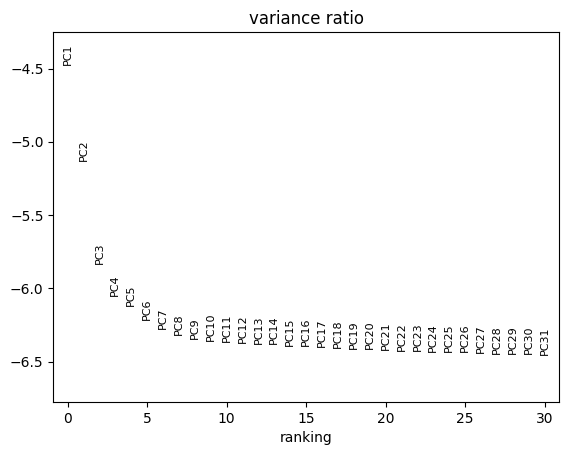

In [3]:
# PCA plot. Notice that wenow use the plot module, abbreviated as "pl"
sc.pl.pca_variance_ratio(scdr, log=True)

It seems obvious that the variance explained by any component after the 10th is quite neglectable. Nevertheless, let's consider up to the 30th component for the subsequent analyses, so that to be sure not to miss any relevant amount of information. At the same time, 30 components are still quite manageable from a computational point of view. 

Interestingly, the components computed by the PCA are automatically stored in the `obsm` field:

In [4]:
scdr.obsm['X_pca']

array([[-2.385142  ,  0.22455417,  1.1968338 , ..., -1.9193275 ,
        -0.7363202 ,  0.32744044],
       [-2.6838467 ,  1.9308625 ,  1.5118648 , ..., -0.49464026,
         1.9030257 ,  0.4870621 ],
       [-3.1059926 ,  2.5579243 ,  0.14404692, ...,  1.3869343 ,
         1.7120938 , -0.12270216],
       ...,
       [ 2.0710607 , -0.7115352 ,  3.9841292 , ..., -1.7088267 ,
         3.2690399 ,  0.15055175],
       [ 7.760118  ,  2.5502272 , -0.4875436 , ..., -0.84836376,
        -0.01186827, -2.0529988 ],
       [ 1.5934509 , -1.0597979 , -0.17745572, ..., -5.7651596 ,
         0.15361026,  0.56893426]], dtype=float32)

The next step is clustering cells in different groups. The scanpy package approaches this problem in two steps: first it identifies for each cell its "closest neighbors", meaning the set of other cells that are more similar in terms of expression profiles. This information is then used to identify the clusters, using the "Leiden" algorithm. You can read more about this algorithm in the other material provided in this module.

In [5]:
# clustering: identification of the closest neighbors. Notice that we use the first 30 components (n_pcs=30)
sc.pp.neighbors(scdr, n_neighbors=10, n_pcs=30)

# clustering: applying the Leiden algorithm
sc.tl.leiden(scdr)

# the clusters are recorded in the 'leiden' column of the obs data fram
scdr.obs['leiden']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

Great! We have now grouped are cells in different clusters and this information is recorded in `obs`. How can we visualize it? While there are several alternatives, the UMAP dimensionality reduction method has become the de-facto standard for this type of visualization

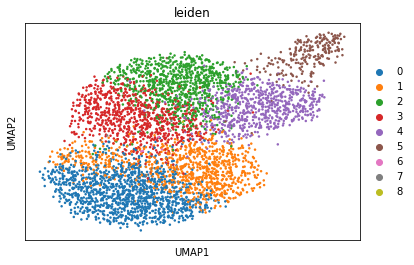

In [7]:
# computing the UMAP
sc.tl.umap(scdr)

# visualizing the UMAP
sc.pl.umap(scdr, color = 'leiden')

The dots in the UMAP represent our single cells. Dots close to each other indicate that the transcriptomics profile of the corresponding cells are similar. Dots are colored according to the clusters found by the Leiden algorithm. Notice how the 7 clusters gracefully separate our cells, with minimal or no overlapping.

We should find the marker genes that characterize each cluster. Ideally, for each cluster we would like to identify genes that are expressed solely in that cluster. While this is often not possible, we can find the genes that are differentially expressed when we compare each cluster against all other cells.

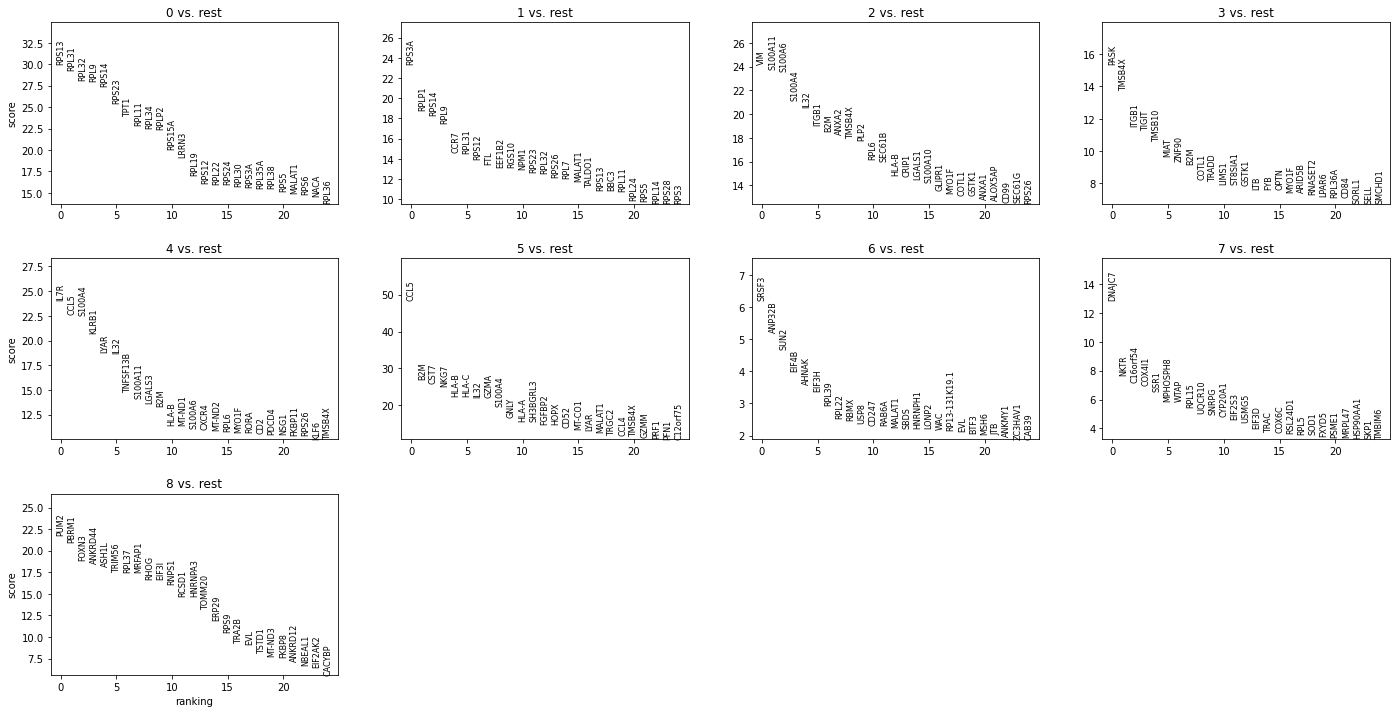

In [8]:
# find the differentially expressed genes characterizing each cluster
sc.tl.rank_genes_groups(scdr, 'leiden', method='t-test')

# for each cluster, plot the 25 most differentially expressed genes
sc.pl.rank_genes_groups(scdr, n_genes=25, sharey=False)

These genes are the markers for each cluster. For example, for cluster 6 we have CCL5, B2M, CST7, NKG7, IL32, GZMA, HLA-B, HLA-C, S100A4, GNLY, and 15 more.

*How can we use this information?*

Cell types that have been studied in biology for a long time. Thus, it is in general possible to know which marker genes we should expect. In the case of Naive and Memory T-cells, the following table provides an overview of some of the known markers:

 Markers | Cell Type
 ---|---
 LRRN3, CCR7, SELL | Naive T-cells (TN)
 PASK | Central Memory T-cells (TCM)
 IL7R, KLRB1, TNFSF13B | Effector Memory T-cells (TEM) 
 CCL4, GZMH, GZMA, GNLY, NKG7, CST7 | Effector Memory T-cells re-expressing CD45RA (TEMRA)

Let's cross check the markers reported in the table with the ones we found in our data. We can see that all known markers for the EMRA T-cells are among the genes characterizing cluster 6: GZMH, CST7, NKG7, GZMA, GNLY, and CCL4. This allows us to confidently assign the TEMRA identity to cluster 6. 

In [9]:
# let's create a new column in obs to store the found identities
scdr.obs['cell_identity'] = ''

# assigning cluster 6 cells to the "EMRA T-cell" type
scdr.obs.loc[scdr.obs.leiden == '6', 'cell_identity'] = 'TEMRA'

Further crossing known markers and differentially expressed genes allows us to realize the following matching:
- Clusters 0, 3, and 5 are characterized by high levels of LRRN3 or CCR7, and thus are recognized as Naive T-cells 
- Clusters 2 is characterized by high levels of PASK, a known marker for Central Memory T-cells
- Cluster 1 is more complex to assign. It shares most of its differentially expressed genes with Cluster 2, and thus it is likely to be formed by Central Memory T-cells 
- All three TEM markers are highly expressed in Clusters 4.
- Clusters 6 was already matched to TEMRA.

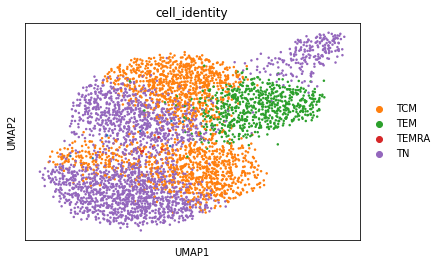

In [10]:
# storing the identified cell types in the "cell_identity" column
ids = (scdr.obs.leiden == '0') | (scdr.obs.leiden == '3') | (scdr.obs.leiden == '5')
scdr.obs.loc[ids, 'cell_identity'] = 'TN'
ids = (scdr.obs.leiden == '1') | (scdr.obs.leiden == '2')
scdr.obs.loc[ids, 'cell_identity'] = 'TCM'
ids = scdr.obs.leiden == '4'
scdr.obs.loc[ids, 'cell_identity'] = 'TEM'

# plotting the UMAP using colors for marking cell identities
sc.pl.umap(scdr, color = 'cell_identity')

The UMAP above gives provides a nice overview of how our vells are separated between different cell types. The Naive T-cells are grouped in the cluster marked with the green color; we managed to subdivide the Memory T-cells between Central Memory, TEM and TEMRA. This shows that our initial hypothesis that Memory T-cells could be a heterogeneous group contaning different subtypes is indeed correct. 

This concludes our cell-type identification analysis. Let's print out the content of `scdr` one last time.

In [11]:
# what is inside scdr at the end of the analyses?
scdr

AnnData object with n_obs × n_vars = 4783 × 1517
    obs: 'cell.type', 'cytokine.condition', 'donor.id', 'batch.10X', 'nGene', 'nUMI', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'cluster.id', 'effectorness', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_identity'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'cell_identity_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can see that `scdr` contains a number of fields that were not present before. This is because anndata objects keep track of all peformed analysis, following the principle that all information regarding the single cell experiment (data, meta data, results) should be recorded in a single object to ensure coherence across the different types of information.